# 0.1 Settings and Importing Modules

In [1]:
from sqlalchemy import create_engine
import pandas as pd
import numpy as np
import pprint
import itertools
import pickle

from mlxtend.plotting import plot_decision_regions
from mlxtend.classifier import StackingClassifier # <-- note: this is not from sklearn!

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_score, recall_score, accuracy_score, roc_auc_score, precision_recall_curve,f1_score, fbeta_score, confusion_matrix, roc_curve, log_loss, make_scorer
from sklearn.preprocessing import StandardScaler,PolynomialFeatures

from numpy import mean
from sklearn import svm, model_selection
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split, GridSearchCV, RepeatedStratifiedKFold, cross_validate

from sklearn.naive_bayes import BernoulliNB, MultinomialNB, GaussianNB
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, ExtraTreesClassifier, VotingClassifier, AdaBoostClassifier, BaggingRegressor
from sklearn.neighbors import KNeighborsClassifier

plt.style.use('ggplot')

%matplotlib inline

# 0.2 Loading Data

In [2]:
pd.set_option('display.max_rows', 150)
pd.set_option('display.float_format', '{:.2f}'.format)
np.set_printoptions(suppress=True)

In [3]:
# loading data from AWS
cnx = create_engine('postgresql://ubuntu@54.157.228.36:5432/steam3tag')

In [4]:
# checking if the dataset is loaded correctly
pd.read_sql_query('''SELECT * FROM steam_3t_strat LIMIT 5''', cnx)

,title,platform,reviewcount,positivepercent,reviewsum,releasedate,originalprice,discountpercentage,afterdiscount,maintag,url,alltags
0,Sid Meier’s Civilization® VI,"Win, Mac, Linux",68938,79,Mostly Positive,2016-10-20,59.99,-70.00,17.99,Strategy,https://store.steampowered.com/app/289070/Sid_...,"Strategy, Turn-Based Strategy, Historical"
1,Tom Clancy's Rainbow Six® Siege,Win,539688,88,Very Positive,2015-12-01,19.99,nan,0.00,FPS,https://store.steampowered.com/app/359550/Tom_...,"FPS, Hero Shooter, Multiplayer"
2,Monster Monpiece,Win,236,74,Mostly Positive,2017-03-14,9.99,nan,0.00,Strategy,https://store.steampowered.com/app/415300/Mons...,"Strategy, Hentai, Deckbuilding"
3,Blackguards 2,"Win, Mac",560,61,Mixed,2015-01-20,129.99,-90.00,12.99,RPG,https://store.steampowered.com/app/314830/Blac...,"RPG, Strategy, Adventure"
4,Void Destroyer,Win,254,67,Mixed,2015-01-20,9.99,nan,0.00,Strategy,https://store.steampowered.com/app/259660/Void...,"Strategy, Simulation, Action"


In [5]:
# some basic feature engineerings have been done and saved as views on AWS using DBeaver, here we will just load it
# for details about what kind of basic feature engineering is done, visit my Medium post: https://medium.com/@opophehu/supervised-classification-a0043d0c5ba5
basic_fe = pd.read_sql_query('''SELECT * FROM basic_fe''', cnx)
basic_fe

,platform,reviewcount,positivepercent,releasedate,originalprice,discountpercentage,alltags,days_since_release,multiplatform,onsale
0,"Win, Mac, Linux",68938,79,2016-10-20,59.99,-70.00,"Strategy, Turn-Based Strategy, Historical",1296,1,1
1,Win,539688,88,2015-12-01,19.99,nan,"FPS, Hero Shooter, Multiplayer",1620,0,0
2,Win,236,74,2017-03-14,9.99,nan,"Strategy, Hentai, Deckbuilding",1151,0,0
3,"Win, Mac",560,61,2015-01-20,129.99,-90.00,"RPG, Strategy, Adventure",1935,1,1
4,Win,254,67,2015-01-20,9.99,nan,"Strategy, Simulation, Action",1935,0,0
...,...,...,...,...,...,...,...,...,...,...
8660,"Win, VR Supported",3,0,2017-12-22,14.99,nan,"Strategy, Indie, VR",868,1,0
8661,Win,6,0,2019-06-19,9.99,nan,"Indie, RPG, Adventure",324,0,0
8662,Win,4,0,2017-09-22,6.99,nan,"Casual, Indie, Strategy",959,0,0
8663,"Win, Mac",4,0,2019-11-16,7.99,nan,"Casual, Indie, Strategy",174,1,0


# 1.1 Cleaning Data
### Dropping NaN and setting floor threshold

##### 1.1.1: dropping unneeded entries

In [6]:
# copy the feature engineered view for exploratory purposes
df = basic_fe.copy()
# dropping unneeded columns
df.drop(['platform', 'releasedate', 'alltags', 'discountpercentage'], axis=1, inplace = True)
# cleaning NaN values
df.fillna(0, inplace=True)
df.describe()

,reviewcount,positivepercent,originalprice,days_since_release,multiplatform,onsale
count,8665.00,8665.00,8665.00,8665.00,8665.00,8665.00
mean,776.28,43.79,9.78,1210.02,0.44,0.06
std,14469.82,38.45,10.35,941.03,0.50,0.24
min,1.00,0.00,0.99,25.00,0.00,0.00
25%,4.00,0.00,3.99,515.00,0.00,0.00
50%,17.00,55.00,6.99,988.00,0.00,0.00
75%,104.00,80.00,12.99,1673.00,1.00,0.00
max,1180658.00,100.00,199.99,7128.00,1.00,1.00


##### 1.1.2: Setting floor threshold at 25%

In [7]:
# setting a floor threshold for review_count based on the information above at 25%
df=df[df.reviewcount>4]

##### 1.1.3: Splitting data

In [8]:
# splitting the data and getting ready to explore
X, y = df.drop('onsale',axis=1), df['onsale']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=42)

##### 1.1.4: Preliminary data viz

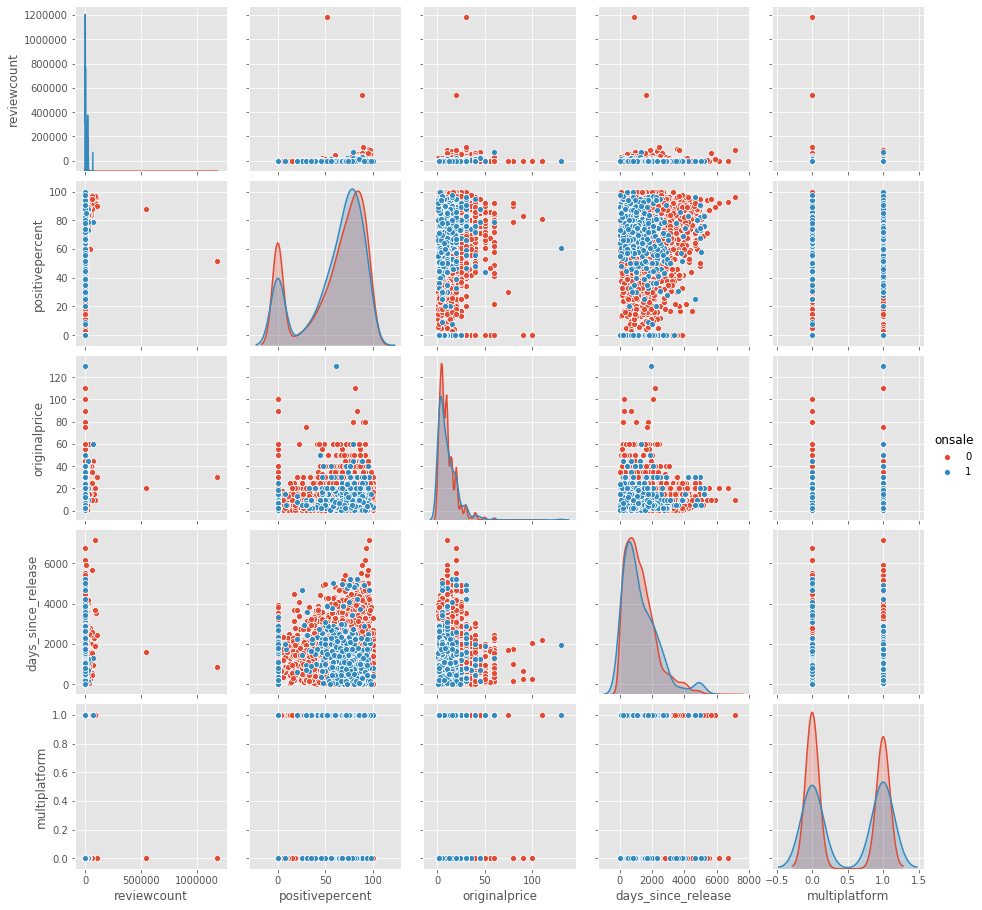

In [9]:
# seeing how this data looks in terms of distinguishablity, in this case, it doesn't look good, extra engineering might need to be done
sns.pairplot(df, hue='onsale');

##### 1.1.5: Class imbalance

In [10]:
# checking class imbalance
df['onsale'].value_counts()

0    5907
1     428
Name: onsale, dtype: int64

In [11]:
# checking class imbalance in terms of %
530/8135

0.06515058389674247

In [12]:
# getting class balance coefficients in order to properly train the model, in this case it would be 1:15 (not_on_sale : on_sale)
8135/530

15.349056603773585

# 2.1 Define Functions
### for classification, feature engineering, and feature selection

##### 2.1.1: Function to run classification models

In [13]:
def classification(X, y, classweight={0:1, 1:1}):
    ''' 
    A function to run all classification models.
    It also automatically filter and selects the best model based on predefined metric (precision, recall, f1). 
    It also prints out detailed information (scores and graph) from each model, including feature importances from Random Forest and Gradient Boosting. 

    Inputs:
    X = Your dataset without the target (y)
    y = Your target, whatever you are trying to predict ---Binary.
    classweight = Your class weights, default is 1 to 1.

    Output:
    Returns the best model based on predefined metric (precision, recall, f1).
    '''
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state=4444)
    
    model_list=[]
    
    # KNN
    knn = KNeighborsClassifier(n_neighbors=5)
    knn.fit(X_train, y_train)
    
    model_list.append(knn)
    
    # Logistic
    lm = LogisticRegression(C=0.95, class_weight = classweight)
    lm.fit(X_train, y_train)
    lm_pred = lm.predict(X_test)
    
    model_list.append(lm)
    
    # Gaussian Naive Bayes
    gnb = GaussianNB()
    gnb.fit(X_train, y_train)
    
    model_list.append(gnb)
    
    # Support Vector Machine   
    svm = SVC(gamma='auto',probability=True, class_weight = classweight)
    svm.fit(X_train, y_train)
    
    model_list.append(svm)
    
    # Decision Tree
    tree = DecisionTreeClassifier(random_state=5, class_weight = classweight)
    tree.fit(X_train, y_train)
    
    model_list.append(tree)
    
    # Random Forest
    ran = RandomForestClassifier(random_state=5, class_weight = classweight)
    ran.fit(X_train, y_train)
    
    model_list.append(ran)
    
    # Gradient Boosting
    gb = GradientBoostingClassifier(n_estimators = 90, max_depth = 100)
    gb.fit(X_train, y_train)
    
    model_list.append(gb)
    
    best_f1_score = 0
    best_model = ran
    
    for model in model_list:
        print (type(model).__name__)
        print ('Accuracy: {:6.4f}'.format(accuracy_score(y_test, model.predict(X_test))))
        print("Precision: {:6.4f},   Recall: {:6.4f},   f1: {:6.4f}".format(precision_score(y_test, model.predict(X_test)), recall_score(y_test, model.predict(X_test)), f1_score(y_test, model.predict(X_test))), '\n')
        
        if f1_score(y_test, model.predict(X_test)) > best_f1_score:
            best_f1_score = f1_score(y_test, model.predict(X_test))
            best_model = model
        
        
        fpr, tpr, thresholds = roc_curve(y_test, model.predict_proba(X_test)[:,1])
        plt.plot(fpr, tpr,lw=2)
        plt.plot([0,1],[0,1],c='violet',ls='--')
        plt.xlim([-0.05,1.05])
        plt.ylim([-0.05,1.05])
        plt.xlabel('False positive rate')
        plt.ylabel('True positive rate')
        plt.title('ROC curve for ' + type(model).__name__);
        print("ROC AUC score = {:6.4f}".format(roc_auc_score(y_test, model.predict_proba(X_test)[:,1])))
        plt.show()
    
    k = list(X.columns)
#     k.remove(y.columns[0])
    pp = pprint.PrettyPrinter(indent=4)
    
    print('\n')
    print("Random Forest feature importances:",'\n')
    pp.pprint(sorted(list(zip(k, ran.feature_importances_)), key=lambda x: x[1], reverse=True))
    
    print('\n')
    print("Gradient Boosting feature importances:",'\n')
    pp.pprint(sorted(list(zip(k, gb.feature_importances_)), key=lambda x: x[1], reverse=True))
    
    print('\n')
    print("Best model is ", type(best_model).__name__)
    print("With f1 score of {:6.4f} and ROC AUC of {:6.4f}".format(f1_score(y_test, best_model.predict(X_test)), roc_auc_score(y_test, best_model.predict_proba(X_test)[:,1])))
    
    return best_model

##### 2.1.2: Function to do exploratory feature engineering

In [14]:
def explore_fe(df, target):
    ''' 
    A function to do exploratory feature engineering. 
    It's flexible in its purpose, and is currently configured for this project only.

    Inputs:
    df (like X) = Your dataset without the target (y)
    target (like y) = Your target, whatever you are trying to predict ---Binary.

    Output:
    Returns engineered X (dataframe without target) based on the engineering logic.
    '''
    df = df.astype(float)
    df = df.replace({0:1 , 1:2})
    
    for i in range (0, len(df.columns)):
        df[f'{df.columns[i]}^2'] = np.square(df[df.columns[i]])
        df[f'{df.columns[i]}^1/2'] = np.sqrt(df[df.columns[i]])
        df[f'{df.columns[i]} * {df.columns[i+1]}'] = df[df.columns[i]] * df[df.columns[i+1]]
        df[f'{df.columns[i]} / {df.columns[i+1]}'] = df[df.columns[i]] / df[df.columns[i+1]]
#         df[f'{df.columns[i]} + {df.columns[i+1]}'] = df[df.columns[i]] + df[df.columns[i+1]]
#         df[f'{df.columns[i]} - {df.columns[i+1]}'] = df[df.columns[i]] - df[df.columns[i+1]]
        

#     df.fillna(0, inplace = True)
#     df.replace([np.inf, -np.inf], np.nan).dropna(axis=1)
    df[~df.isin([np.nan, np.inf, -np.inf]).any(1)].astype(np.float64)
    
    X,y= df, target
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state=4444)
    
    ran = RandomForestClassifier(random_state=5)
    ran.fit(X_train, y_train)
    
    print ('Accuracy: ', accuracy_score(y_test, ran.predict(X_test)))
    print("Precision: {:6.4f},   Recall: {:6.4f},   f1: {:6.4f}".format(precision_score(y_test, ran.predict(X_test)), 
                                                 recall_score(y_test, ran.predict(X_test)), f1_score(y_test, ran.predict(X_test))), '\n')
    
    k = list(X.columns)
    pp = pprint.PrettyPrinter(indent=4)
    pp.pprint(sorted(list(zip(k, ran.feature_importances_)), key=lambda x: x[1], reverse=True))
    
    return df

##### 2.1.3: Function to poly transform columns

In [15]:
def PolynomialFeatures_labeled(input_df,power):
    '''
    Basically this is a cover for the sklearn preprocessing function. 
    The problem with that function is if you give it a labeled dataframe, it ouputs an unlabeled dataframe with potentially
    a whole bunch of unlabeled columns. 

    Inputs:
    input_df = Your labeled pandas dataframe (list of x's not raised to any power) 
    power = what order polynomial you want variables up to. (use the same power as you want entered into pp.PolynomialFeatures(power) directly)

    Output:
    Output: This function relies on the powers_ matrix which is one of the preprocessing function's outputs to create logical labels and 
    outputs a labeled pandas dataframe   
    '''
    poly = PolynomialFeatures(power)
    output_nparray = poly.fit_transform(input_df)
    powers_nparray = poly.powers_

    input_feature_names = list(input_df.columns)
    target_feature_names = ["Constant Term"]
    for feature_distillation in powers_nparray[1:]:
        intermediary_label = ""
        final_label = ""
        for i in range(len(input_feature_names)):
            if feature_distillation[i] == 0:
                continue
            else:
                variable = input_feature_names[i]
                power = feature_distillation[i]
                intermediary_label = "%s^%d" % (variable,power)
                if final_label == "":         #If the final label isn't yet specified
                    final_label = intermediary_label
                else:
                    final_label = final_label + " x " + intermediary_label
        target_feature_names.append(final_label)
    output_df = pd.DataFrame(output_nparray, columns = target_feature_names)
    return output_df

##### 2.1.4: Function to select features in order to reduce noise

In [16]:
from sklearn.feature_selection import SelectFromModel, RFE, SelectKBest, chi2
from sklearn.preprocessing import MinMaxScaler
from lightgbm import LGBMClassifier

In [17]:
def feature_selection(X, y, score_to_keep = 5):
    '''
    A function to select features by votes of 6 models who can calculate feature importances.
    Also prints out how many original features there are, how many selected, and a list of selected features.
    Original idea from https://www.kaggle.com/mlwhiz/feature-selection-using-football-data

    Inputs:
    X = Your dataset without the target (y)
    y = Your target, whatever you are trying to predict --- Binary.
    score_to_keep = Pick features that have a 'score_to_keep' amount of votes --- max is 6 votes, default is 5. 
    
    Output:
    Returns selected_X as a dataframe without target(y). 
    '''
    feature_name = list(X.columns)
    num_feats=len(X.columns)
    def cor_selector(X, y,num_feats):
        cor_list = []
        feature_name = X.columns.tolist()
        # calculate the correlation with y for each feature
        for i in X.columns.tolist():
            cor = np.corrcoef(X[i], y)[0, 1]
            cor_list.append(cor)
        # replace NaN with 0
        cor_list = [0 if np.isnan(i) else i for i in cor_list]
        # feature name
        cor_feature = X.iloc[:,np.argsort(np.abs(cor_list))[-num_feats:]].columns.tolist()
        # feature selection? 0 for not select, 1 for select
        cor_support = [True if i in cor_feature else False for i in feature_name]
        return cor_support, cor_feature
    cor_support, cor_feature = cor_selector(X, y,num_feats)
    
    X_norm = MinMaxScaler().fit_transform(X)
    chi_selector = SelectKBest(chi2, k=num_feats)
    chi_selector.fit(X_norm, y)
    chi_support = chi_selector.get_support()
    chi_feature = X.loc[:,chi_support].columns.tolist()
    
    rfe_selector = RFE(estimator=LogisticRegression(), n_features_to_select=num_feats, step=10, verbose=5)
    rfe_selector.fit(X_norm, y)
    rfe_support = rfe_selector.get_support()
    rfe_feature = X.loc[:,rfe_support].columns.tolist()
    
    embeded_lr_selector = SelectFromModel(LogisticRegression(penalty="l2"), max_features=num_feats)
    embeded_lr_selector.fit(X_norm, y)
    embeded_lr_support = embeded_lr_selector.get_support()
    embeded_lr_feature = X.loc[:,embeded_lr_support].columns.tolist()
    
    embeded_rf_selector = SelectFromModel(RandomForestClassifier(n_estimators=100), max_features=num_feats)
    embeded_rf_selector.fit(X_norm, y)
    embeded_rf_support = embeded_rf_selector.get_support()
    embeded_rf_feature = X.loc[:,embeded_rf_support].columns.tolist()
    
    lgbc=LGBMClassifier(n_estimators=500, learning_rate=0.05, num_leaves=32, colsample_bytree=0.2,
            reg_alpha=3, reg_lambda=1, min_split_gain=0.01, min_child_weight=40)
    embeded_lgb_selector = SelectFromModel(lgbc, max_features=num_feats)
    embeded_lgb_selector.fit(X_norm, y)
    embeded_lgb_support = embeded_lgb_selector.get_support()
    embeded_lgb_feature = X.loc[:,embeded_lgb_support].columns.tolist()
    
    feature_selection_df = pd.DataFrame({'Feature':feature_name, 'Pearson':cor_support, 'Chi-2':chi_support, 'RFE':rfe_support, 'Logistics':embeded_lr_support,
                                        'Random Forest':embeded_rf_support, 'LightGBM':embeded_lgb_support})
    
    feature_selection_df['Total'] = np.sum(feature_selection_df, axis=1)
    
    feature_selection_df = feature_selection_df.sort_values(['Total','Feature'] , ascending=False)
    feature_selection_df.index = range(1, len(feature_selection_df)+1)
    
    
    selected_X = X.copy()
    to_drop = []
    for i in range (0, len(feature_selection_df)):
        if feature_selection_df.Total.values[i] < score_to_keep:
            to_drop.append(feature_selection_df.Feature.values[i])

    selected_X = selected_X.drop(to_drop, axis = 1)
    
    print ("Number of orginal features: ", num_feats)
    print ("Number of selected features: ", len(selected_X.columns), '\n')
    pp = pprint.PrettyPrinter(indent=4)
    print("Selected Features:")
    pp.pprint(list(selected_X.columns))
    
    
    return selected_X

# 3.1 Exploratory Model Building
### Logistic regression vs. Naive Bayes and exploratory grid search

##### 3.1.1: Grid search with logistic regression

In [18]:
# define model
model = LogisticRegression(solver='lbfgs')

# define grid
balance = [{0:100,1:1}, {0:10,1:1}, {0:1,1:1}, {0:1,1:10}, {0:1,1:100}]
param_grid = dict(class_weight=balance)

# define evaluation procedure
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)

# define grid search
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=cv, scoring='roc_auc')

# execute the grid search
grid_result = grid.fit(X_train, y_train)

# report the best configuration
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

# report all configurations
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.513234 using {'class_weight': {0: 1, 1: 100}}
0.469527 (0.055367) with: {'class_weight': {0: 100, 1: 1}}
0.465070 (0.052545) with: {'class_weight': {0: 10, 1: 1}}
0.475504 (0.046511) with: {'class_weight': {0: 1, 1: 1}}
0.486021 (0.047743) with: {'class_weight': {0: 1, 1: 10}}
0.513234 (0.048793) with: {'class_weight': {0: 1, 1: 100}}


##### 3.1.2: Explore skillfulness with this class weight

ROC AUC score =  0.5194194647516767


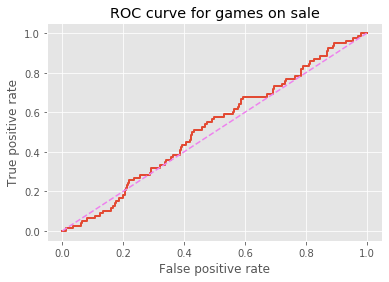

In [19]:
fpr, tpr, thresholds = roc_curve(y_test, grid_result.predict_proba(X_test)[:,1])

plt.plot(fpr, tpr,lw=2)
plt.plot([0,1],[0,1],c='violet',ls='--')
plt.xlim([-0.05,1.05])
plt.ylim([-0.05,1.05])


plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve for games on sale');
print("ROC AUC score = ", roc_auc_score(y_test, grid_result.predict_proba(X_test)[:,1]))

##### 3.1.3: Compare against dummy classifier

In [20]:
from sklearn.dummy import DummyClassifier

dc = DummyClassifier()
dc.fit(X_train, y_train)
print("Log-loss on logit: {:6.4f}".format(log_loss(y_test, grid_result.predict_proba(X_test))))
print("Log-loss on dummy classifier: {:6.4f}".format(log_loss(y_test, dc.predict_proba(X_test))))

Log-loss on logit: 2.0039
Log-loss on dummy classifier: 4.1163


F:\Anaconda\lib\site-packages\sklearn\dummy.py:132: FutureWarning: The default value of strategy will change from stratified to prior in 0.24.
  "stratified to prior in 0.24.", FutureWarning)


In [21]:
print("Logistic accuracy: {:6.4f}".format(grid_result.score(X_test, y_test)))
print("Dummy accuracy: {:6.4f}".format(dc.score(X_test, y_test)))

Logistic accuracy: 0.5194
Dummy accuracy: 0.8808


##### 3.1.4: Explore pure probability classification with Naive Bayes

In [22]:
nb = GaussianNB()
nb.fit(X_train, y_train)
nb.score(X_test, y_test)

0.9179163378058406

##### 3.1.5: Explore skillfulness with no class weight

ROC AUC score =  0.5141575553686571


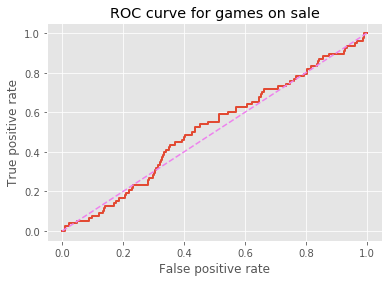

In [23]:
fpr, tpr, thresholds = roc_curve(y_test, nb.predict_proba(X_test)[:,1])

plt.plot(fpr, tpr,lw=2)
plt.plot([0,1],[0,1],c='violet',ls='--')
plt.xlim([-0.05,1.05])
plt.ylim([-0.05,1.05])


plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve for games on sale');
print("ROC AUC score = ", roc_auc_score(y_test, nb.predict_proba(X_test)[:,1]))

# 3.2 Establish baseline model

KNeighborsClassifier
Accuracy: 0.9258
Precision: 0.6000,   Recall: 0.0211,   f1: 0.0408 

ROC AUC score = 0.5778


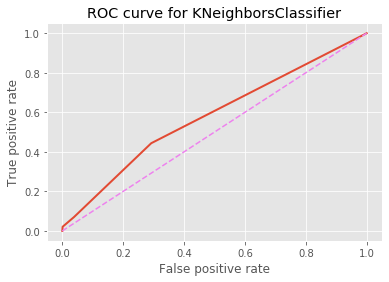

LogisticRegression
Accuracy: 0.0857
Precision: 0.0719,   Recall: 0.9437,   f1: 0.1336 

ROC AUC score = 0.4904


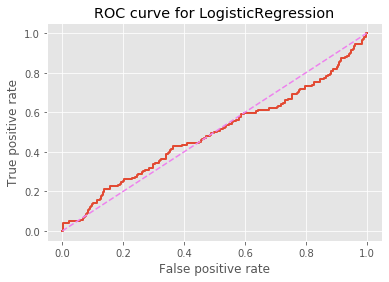

GaussianNB
Accuracy: 0.9248
Precision: 0.3333,   Recall: 0.0070,   f1: 0.0138 

ROC AUC score = 0.5555


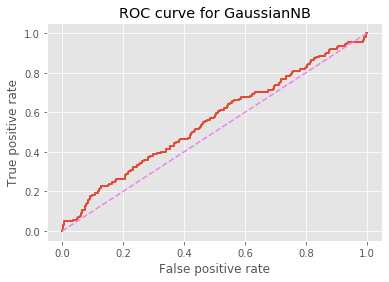

SVC
Accuracy: 0.9300
Precision: 0.9091,   Recall: 0.0704,   f1: 0.1307 

ROC AUC score = 0.5856


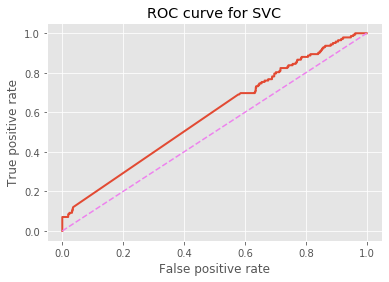

DecisionTreeClassifier
Accuracy: 0.8943
Precision: 0.2521,   Recall: 0.2113,   f1: 0.2299 

ROC AUC score = 0.5804


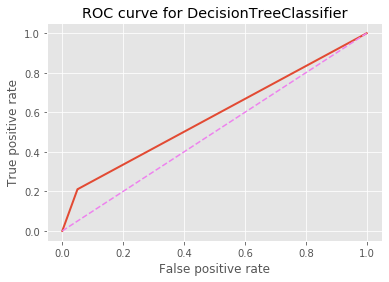

RandomForestClassifier
Accuracy: 0.9327
Precision: 0.7692,   Recall: 0.1408,   f1: 0.2381 

ROC AUC score = 0.6741


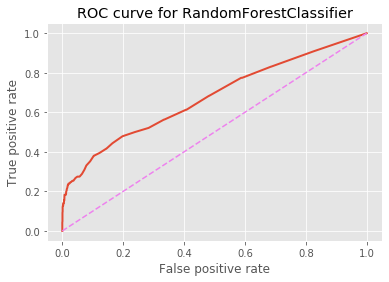

GradientBoostingClassifier
Accuracy: 0.8974
Precision: 0.2846,   Recall: 0.2465,   f1: 0.2642 

ROC AUC score = 0.6824


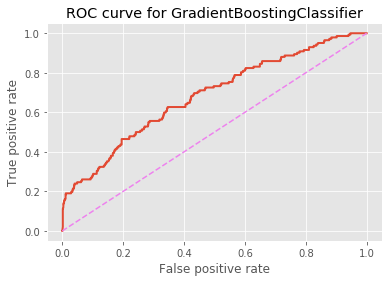



Random Forest feature importances: 

[   ('days_since_release', 0.34450602680082204),
    ('reviewcount', 0.253510064982744),
    ('positivepercent', 0.19696673040903423),
    ('originalprice', 0.16713633365096686),
    ('multiplatform', 0.037880844156432975)]


Gradient Boosting feature importances: 

[   ('days_since_release', 0.4257914749311288),
    ('reviewcount', 0.20857251105695843),
    ('positivepercent', 0.175113281146018),
    ('originalprice', 0.12543564439296434),
    ('multiplatform', 0.06508708847293034)]


Best model is  GradientBoostingClassifier
With f1 score of 0.2642 and ROC AUC of 0.6824


In [24]:
baseline_model = classification(X, y, {0: 1, 1: 15})

# 4.1 Exploratory Feature Engineering
### Feature multiplication and Feature division

##### 4.1.1: Transform the dataset using custom algorithm

In [25]:
explore_X = explore_fe(X, y)

Accuracy:  0.9347711730668069
Precision: 0.7500,   Recall: 0.1901,   f1: 0.3034 

[   ('days_since_release * multiplatform', 0.0768935186875429),
    ('originalprice * days_since_release', 0.0677956332261179),
    ('days_since_release^1/2', 0.06708850452933726),
    ('originalprice / days_since_release', 0.06619556721545207),
    ('days_since_release / multiplatform', 0.0654260253921697),
    ('days_since_release^2', 0.06495960987992966),
    ('days_since_release', 0.06420175997183804),
    ('positivepercent / originalprice', 0.048778289770846375),
    ('reviewcount / positivepercent', 0.045992898325221736),
    ('positivepercent * originalprice', 0.04433662821372608),
    ('multiplatform * reviewcount^2', 0.041338024508266014),
    ('reviewcount * positivepercent', 0.03825089541880164),
    ('multiplatform / reviewcount^2', 0.03788363345223486),
    ('reviewcount', 0.037237804728187454),
    ('reviewcount^1/2', 0.03555988924023135),
    ('reviewcount^2', 0.03403154913038406),
    ('po

##### 4.1.2: Compare metrics and determine effectiveness of the above F.E.

KNeighborsClassifier
Accuracy: 0.9227
Precision: 0.3077,   Recall: 0.0282,   f1: 0.0516 

ROC AUC score = 0.6280


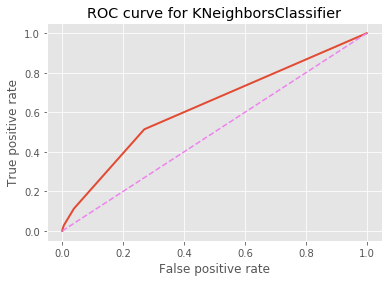

LogisticRegression
Accuracy: 0.0794
Precision: 0.0728,   Recall: 0.9648,   f1: 0.1354 

ROC AUC score = 0.4892


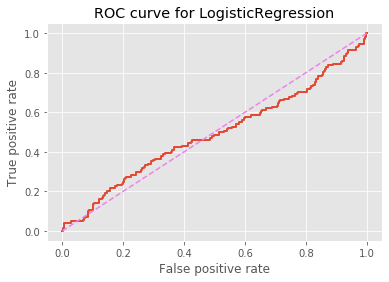

GaussianNB
Accuracy: 0.0794
Precision: 0.0737,   Recall: 0.9789,   f1: 0.1371 

ROC AUC score = 0.5543


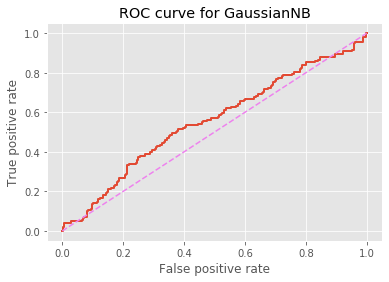

SVC
Accuracy: 0.9295
Precision: 1.0000,   Recall: 0.0563,   f1: 0.1067 

ROC AUC score = 0.5414


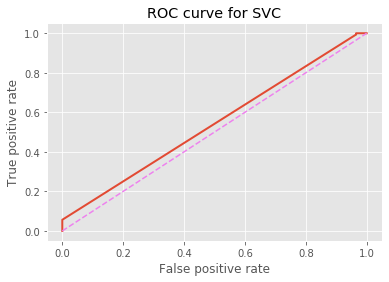

DecisionTreeClassifier
Accuracy: 0.8901
Precision: 0.2443,   Recall: 0.2254,   f1: 0.2344 

ROC AUC score = 0.5845


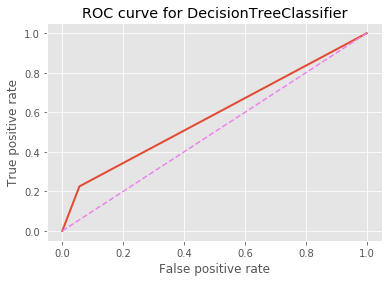

RandomForestClassifier
Accuracy: 0.9316
Precision: 0.7143,   Recall: 0.1408,   f1: 0.2353 

ROC AUC score = 0.6733


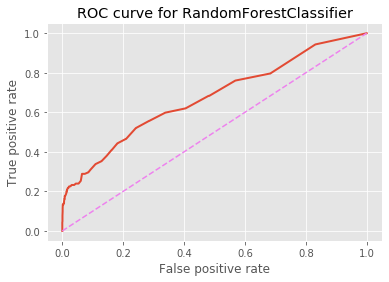

GradientBoostingClassifier
Accuracy: 0.8916
Precision: 0.2460,   Recall: 0.2183,   f1: 0.2313 

ROC AUC score = 0.6292


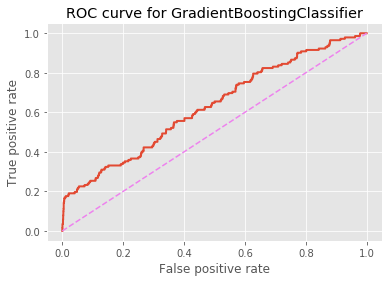



Random Forest feature importances: 

[   ('days_since_release * multiplatform', 0.06848929352160371),
    ('originalprice * days_since_release', 0.06589455423554681),
    ('originalprice / days_since_release', 0.06514222298848894),
    ('days_since_release / multiplatform', 0.05778479546480035),
    ('positivepercent / originalprice', 0.05755980836772065),
    ('reviewcount / positivepercent', 0.0572306350698457),
    ('days_since_release^2', 0.056633989549268016),
    ('days_since_release^1/2', 0.05581809950930204),
    ('days_since_release', 0.053536591490595406),
    ('positivepercent * originalprice', 0.05000473391934461),
    ('multiplatform * reviewcount^2', 0.0439232933738301),
    ('reviewcount * positivepercent', 0.040689658825224),
    ('multiplatform / reviewcount^2', 0.03891457639446194),
    ('reviewcount^2', 0.03683103041697992),
    ('positivepercent', 0.03534657433078488),
    ('reviewcount', 0.03529562435478027),
    ('positivepercent^1/2', 0.03384875220072895),
    

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                       class_weight={0: 1, 1: 15}, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=5, verbose=0, warm_start=False)

In [26]:
classification(explore_X, y, {0: 1, 1: 15})

# 4.2 Feature Selection based on custom F.E.

##### 4.2.0: Test feature selection algorithm on pre engineered dataframe

In [27]:
feature_selection(X, y)

Number of orginal features:  5
Number of selected features:  2 

Selected Features:
['reviewcount', 'days_since_release']


,reviewcount,days_since_release
0,68938,1296
1,539688,1620
2,236,1151
3,560,1935
4,254,1935
...,...,...
8656,5,1102
8657,2204,2739
8658,6,639
8659,8,679


##### 4.2.1: Filter Exploratory F.E.'d dataframe from 4.1 (features with at least 5 votes)

In [28]:
exp_X_sel = feature_selection(explore_X, y)

Number of orginal features:  25
Number of selected features:  12 

Selected Features:
[   'reviewcount',
    'days_since_release',
    'reviewcount / positivepercent',
    'positivepercent * originalprice',
    'positivepercent / originalprice',
    'originalprice * days_since_release',
    'originalprice / days_since_release',
    'days_since_release^2',
    'days_since_release^1/2',
    'days_since_release * multiplatform',
    'days_since_release / multiplatform',
    'multiplatform / reviewcount^2']


##### 4.2.2: Run modeling algorithm to check metrics

KNeighborsClassifier
Accuracy: 0.9243
Precision: 0.4615,   Recall: 0.0845,   f1: 0.1429 

ROC AUC score = 0.5952


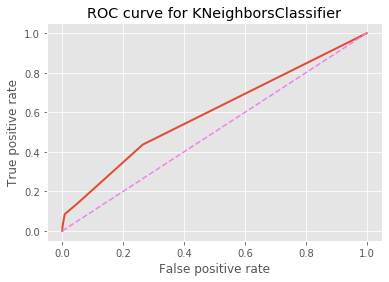

LogisticRegression
Accuracy: 0.5487
Precision: 0.0959,   Recall: 0.5986,   f1: 0.1654 

ROC AUC score = 0.6068


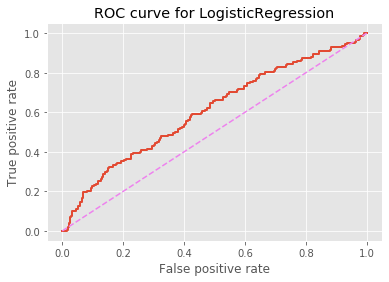

GaussianNB
Accuracy: 0.8811
Precision: 0.0962,   Recall: 0.0704,   f1: 0.0813 

ROC AUC score = 0.5692


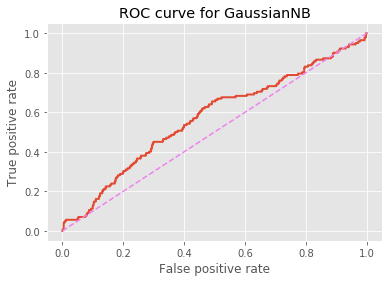

SVC
Accuracy: 0.9300
Precision: 1.0000,   Recall: 0.0634,   f1: 0.1192 

ROC AUC score = 0.5596


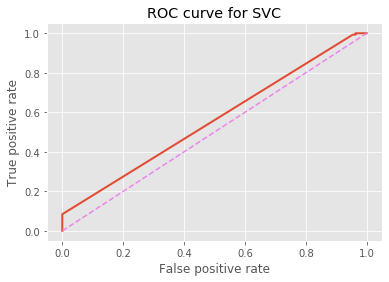

DecisionTreeClassifier
Accuracy: 0.8927
Precision: 0.2328,   Recall: 0.1901,   f1: 0.2093 

ROC AUC score = 0.5698


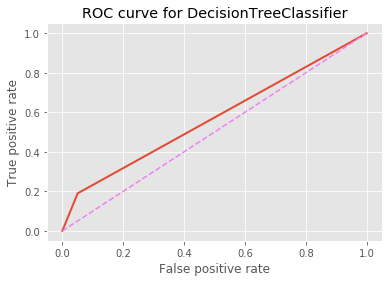

RandomForestClassifier
Accuracy: 0.9316
Precision: 0.7143,   Recall: 0.1408,   f1: 0.2353 

ROC AUC score = 0.6549


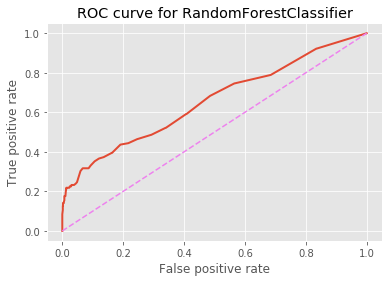

GradientBoostingClassifier
Accuracy: 0.8874
Precision: 0.2231,   Recall: 0.2042,   f1: 0.2132 

ROC AUC score = 0.6531


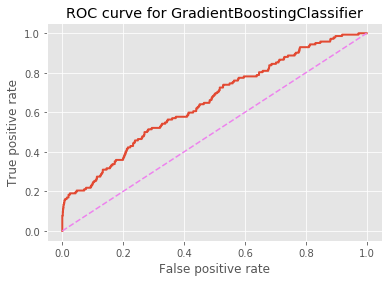



Random Forest feature importances: 

[   ('days_since_release * multiplatform', 0.09756751696981801),
    ('originalprice / days_since_release', 0.095165373828351),
    ('reviewcount / positivepercent', 0.09486076860366552),
    ('positivepercent / originalprice', 0.09299650446805244),
    ('originalprice * days_since_release', 0.09279653729373911),
    ('days_since_release / multiplatform', 0.08579299387528583),
    ('positivepercent * originalprice', 0.084582873594917),
    ('days_since_release', 0.0743673270522363),
    ('days_since_release^2', 0.07264645859556586),
    ('reviewcount', 0.07238047122003682),
    ('days_since_release^1/2', 0.07137415113066763),
    ('multiplatform / reviewcount^2', 0.06546902336766453)]


Gradient Boosting feature importances: 

[   ('originalprice * days_since_release', 0.13546965187435456),
    ('positivepercent / originalprice', 0.1239037654472637),
    ('originalprice / days_since_release', 0.11967705068634046),
    ('reviewcount / positiveperce

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                       class_weight={0: 1, 1: 15}, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=5, verbose=0, warm_start=False)

In [29]:
classification(exp_X_sel, y, {0: 1, 1: 15})

##### 4.2.3: Filter Exploratory F.E.'d dataframe from 4.1 (features with at least 6 (max) votes)

In [30]:
exp_X_sel_6 = feature_selection(explore_X, y, 6)

Number of orginal features:  25
Number of selected features:  7 

Selected Features:
[   'positivepercent * originalprice',
    'positivepercent / originalprice',
    'originalprice * days_since_release',
    'originalprice / days_since_release',
    'days_since_release^2',
    'days_since_release * multiplatform',
    'days_since_release / multiplatform']


##### 4.2.4: Run modeling algorithm to check metrics

KNeighborsClassifier
Accuracy: 0.9243
Precision: 0.4615,   Recall: 0.0845,   f1: 0.1429 

ROC AUC score = 0.6003


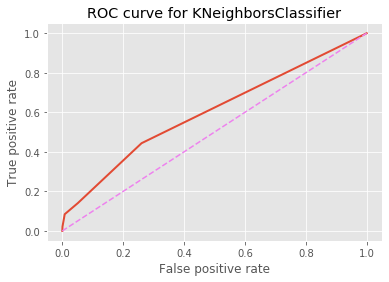

LogisticRegression
Accuracy: 0.0747
Precision: 0.0747,   Recall: 1.0000,   f1: 0.1390 

ROC AUC score = 0.4931


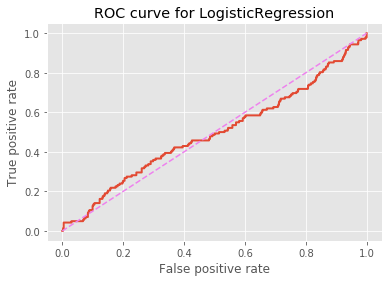

GaussianNB
Accuracy: 0.8953
Precision: 0.1200,   Recall: 0.0634,   f1: 0.0829 

ROC AUC score = 0.5855


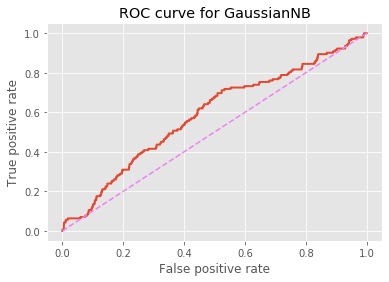

SVC
Accuracy: 0.9300
Precision: 1.0000,   Recall: 0.0634,   f1: 0.1192 

ROC AUC score = 0.5699


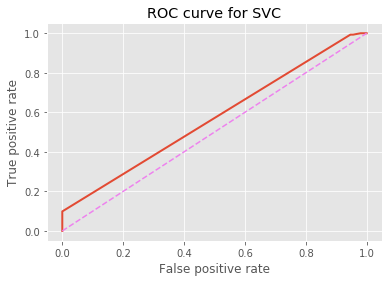

DecisionTreeClassifier
Accuracy: 0.8832
Precision: 0.2183,   Recall: 0.2183,   f1: 0.2183 

ROC AUC score = 0.5777


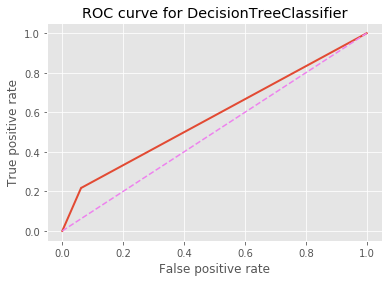

RandomForestClassifier
Accuracy: 0.9337
Precision: 0.7353,   Recall: 0.1761,   f1: 0.2841 

ROC AUC score = 0.6271


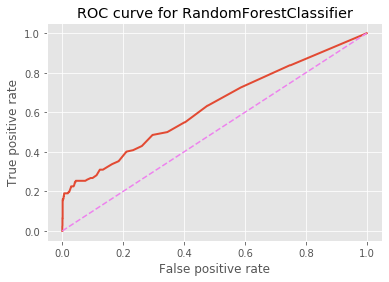

GradientBoostingClassifier
Accuracy: 0.8922
Precision: 0.2261,   Recall: 0.1831,   f1: 0.2023 

ROC AUC score = 0.6542


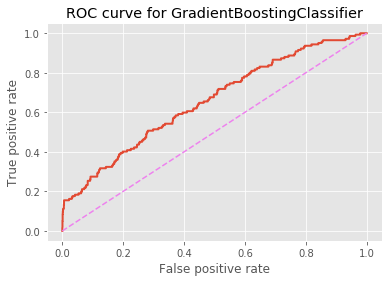



Random Forest feature importances: 

[   ('days_since_release * multiplatform', 0.15733632854594953),
    ('originalprice / days_since_release', 0.15283800633383385),
    ('originalprice * days_since_release', 0.1458297387972686),
    ('days_since_release / multiplatform', 0.1444120563872032),
    ('days_since_release^2', 0.13754631184183416),
    ('positivepercent / originalprice', 0.1343817311588042),
    ('positivepercent * originalprice', 0.12765582693510658)]


Gradient Boosting feature importances: 

[   ('originalprice / days_since_release', 0.18445309349022318),
    ('originalprice * days_since_release', 0.17007328119199694),
    ('positivepercent / originalprice', 0.16756957798986244),
    ('positivepercent * originalprice', 0.14182790708473397),
    ('days_since_release * multiplatform', 0.1252601624323447),
    ('days_since_release / multiplatform', 0.10905283378302026),
    ('days_since_release^2', 0.10176314402781873)]


Best model is  RandomForestClassifier
With f1 scor

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                       class_weight={0: 1, 1: 15}, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=5, verbose=0, warm_start=False)

In [31]:
classification(exp_X_sel_6, y, {0: 1, 1: 15})

# 5.1 Poly FE
### Polynomial Transformation and feature selection

##### 5.1.1: Poly transform the original dataframe

In [32]:
explore_X_poly=PolynomialFeatures_labeled(X,2)

##### 5.1.2: Check scores before feature selection

KNeighborsClassifier
Accuracy: 0.9232
Precision: 0.2500,   Recall: 0.0141,   f1: 0.0267 

ROC AUC score = 0.5788


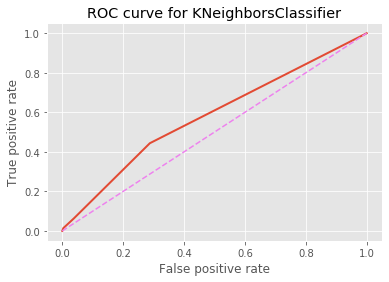

LogisticRegression
Accuracy: 0.1320
Precision: 0.0711,   Recall: 0.8803,   f1: 0.1316 

ROC AUC score = 0.4889


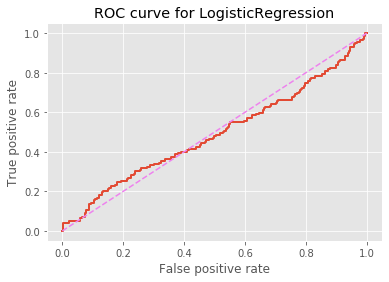

GaussianNB
Accuracy: 0.0873
Precision: 0.0729,   Recall: 0.9577,   f1: 0.1355 

ROC AUC score = 0.5535


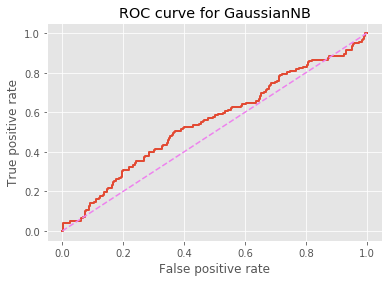

SVC
Accuracy: 0.9295
Precision: 1.0000,   Recall: 0.0563,   f1: 0.1067 

ROC AUC score = 0.5443


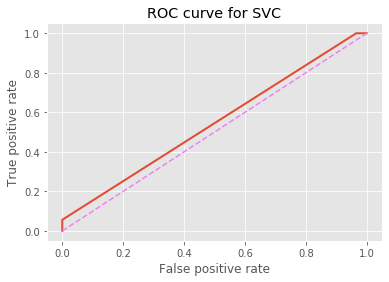

DecisionTreeClassifier
Accuracy: 0.8874
Precision: 0.2273,   Recall: 0.2113,   f1: 0.2190 

ROC AUC score = 0.5766


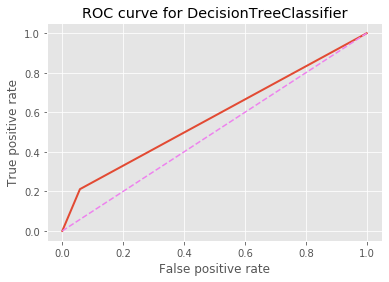

RandomForestClassifier
Accuracy: 0.9332
Precision: 0.8261,   Recall: 0.1338,   f1: 0.2303 

ROC AUC score = 0.6554


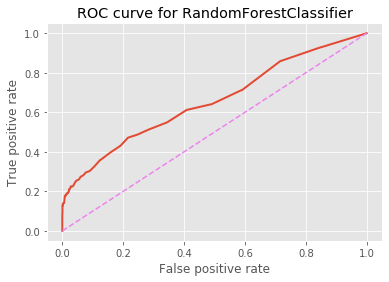

GradientBoostingClassifier
Accuracy: 0.8943
Precision: 0.2677,   Recall: 0.2394,   f1: 0.2528 

ROC AUC score = 0.6730


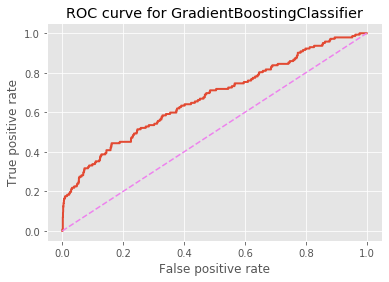



Random Forest feature importances: 

[   ('originalprice^1 x days_since_release^1', 0.09238894041597694),
    ('reviewcount^1 x days_since_release^1', 0.08333150245223529),
    ('days_since_release^1', 0.07996610365714672),
    ('days_since_release^2', 0.07721324028352354),
    ('reviewcount^1 x originalprice^1', 0.06460927682671587),
    ('positivepercent^1 x originalprice^1', 0.061672969239095515),
    ('positivepercent^1 x days_since_release^1', 0.06009050560281371),
    ('reviewcount^2', 0.05824851553597868),
    ('reviewcount^1', 0.055310855406481126),
    ('positivepercent^1', 0.05330669345629728),
    ('reviewcount^1 x positivepercent^1', 0.05286321412219654),
    ('positivepercent^2', 0.049728753284767724),
    ('days_since_release^1 x multiplatform^1', 0.04607024303614038),
    ('originalprice^1', 0.03660620418812921),
    ('originalprice^2', 0.036497227658448844),
    ('reviewcount^1 x multiplatform^1', 0.032944314494692546),
    ('originalprice^1 x multiplatform^1', 0.0289

GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=100,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=90,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=None, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

In [33]:
classification(explore_X_poly, y, {0: 1, 1: 15})

##### 5.1.3: Select feature by either 5 or 6 votes

In [34]:
exp_Xpoly_sel_5 = feature_selection(explore_X_poly, y, 5)
exp_Xpoly_sel_6 = feature_selection(explore_X_poly, y, 6)

F:\Anaconda\lib\site-packages\numpy\lib\function_base.py:2534: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
F:\Anaconda\lib\site-packages\numpy\lib\function_base.py:2535: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


Number of orginal features:  21
Number of selected features:  10 

Selected Features:
[   'reviewcount^1',
    'positivepercent^1',
    'days_since_release^1',
    'reviewcount^1 x originalprice^1',
    'reviewcount^1 x days_since_release^1',
    'positivepercent^1 x originalprice^1',
    'positivepercent^1 x days_since_release^1',
    'originalprice^1 x days_since_release^1',
    'days_since_release^2',
    'days_since_release^1 x multiplatform^1']


F:\Anaconda\lib\site-packages\numpy\lib\function_base.py:2534: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
F:\Anaconda\lib\site-packages\numpy\lib\function_base.py:2535: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


Number of orginal features:  21
Number of selected features:  3 

Selected Features:
[   'days_since_release^1',
    'positivepercent^1 x days_since_release^1',
    'days_since_release^2']


##### 5.1.4: Run modeling algorithm to check metrics

KNeighborsClassifier
Accuracy: 0.9232
Precision: 0.3333,   Recall: 0.0282,   f1: 0.0519 

ROC AUC score = 0.5862


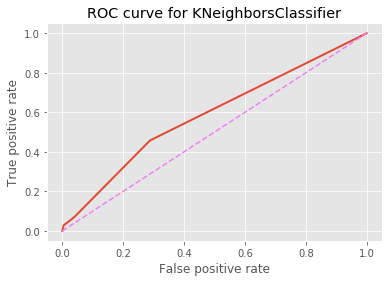

LogisticRegression
Accuracy: 0.4945
Precision: 0.0851,   Recall: 0.5915,   f1: 0.1488 

ROC AUC score = 0.5850


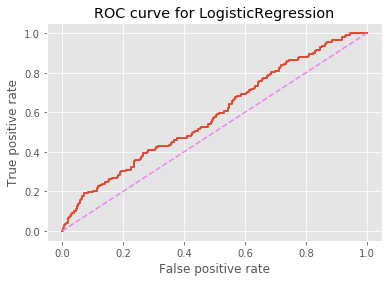

GaussianNB
Accuracy: 0.8716
Precision: 0.0750,   Recall: 0.0634,   f1: 0.0687 

ROC AUC score = 0.5494


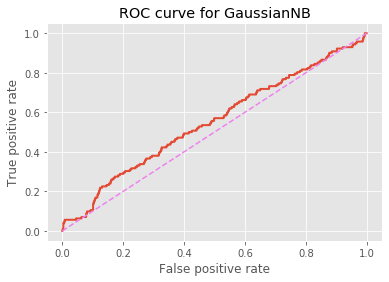

SVC
Accuracy: 0.9295
Precision: 1.0000,   Recall: 0.0563,   f1: 0.1067 

ROC AUC score = 0.5443


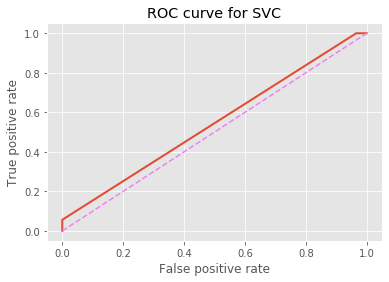

DecisionTreeClassifier
Accuracy: 0.8901
Precision: 0.2320,   Recall: 0.2042,   f1: 0.2172 

ROC AUC score = 0.5748


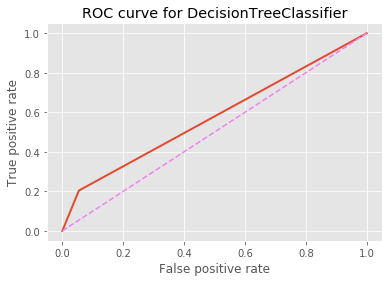

RandomForestClassifier
Accuracy: 0.9332
Precision: 0.8261,   Recall: 0.1338,   f1: 0.2303 

ROC AUC score = 0.6583


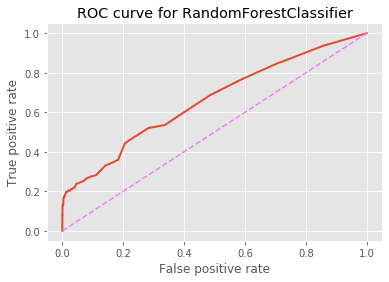

GradientBoostingClassifier
Accuracy: 0.8995
Precision: 0.2906,   Recall: 0.2394,   f1: 0.2625 

ROC AUC score = 0.6838


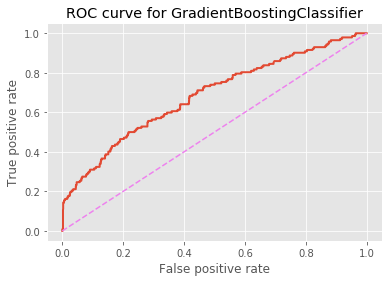



Random Forest feature importances: 

[   ('originalprice^1 x days_since_release^1', 0.12753123228349963),
    ('reviewcount^1 x days_since_release^1', 0.11446123512829984),
    ('days_since_release^1', 0.10834212436402627),
    ('days_since_release^2', 0.10470154483934369),
    ('reviewcount^1 x originalprice^1', 0.10379729279820495),
    ('reviewcount^1', 0.09689880179319575),
    ('positivepercent^1 x originalprice^1', 0.09464281009479372),
    ('positivepercent^1 x days_since_release^1', 0.08637581686757571),
    ('positivepercent^1', 0.08489005473083029),
    ('days_since_release^1 x multiplatform^1', 0.07835908710023014)]


Gradient Boosting feature importances: 

[   ('originalprice^1 x days_since_release^1', 0.17855973234695227),
    ('reviewcount^1 x days_since_release^1', 0.13786713756121696),
    ('positivepercent^1 x originalprice^1', 0.11047176052576416),
    ('reviewcount^1 x originalprice^1', 0.10512123201391813),
    ('positivepercent^1', 0.08644169203579077),
    ('da

In [35]:
best_model=classification(exp_Xpoly_sel_5, y, {0: 1, 1: 15})

KNeighborsClassifier
Accuracy: 0.9237
Precision: 0.4286,   Recall: 0.0634,   f1: 0.1104 

ROC AUC score = 0.6139


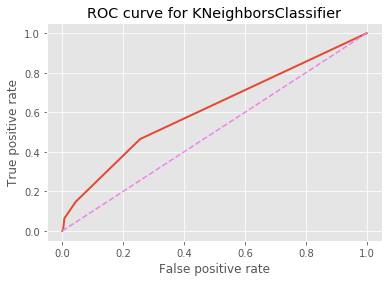

LogisticRegression
Accuracy: 0.6739
Precision: 0.0777,   Recall: 0.3099,   f1: 0.1243 

ROC AUC score = 0.5391


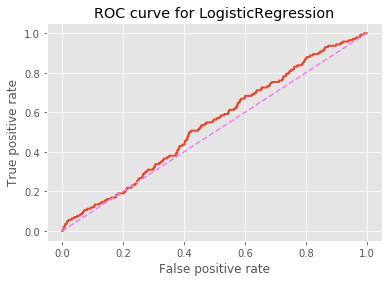

GaussianNB
Accuracy: 0.9153
Precision: 0.1935,   Recall: 0.0423,   f1: 0.0694 

ROC AUC score = 0.5658


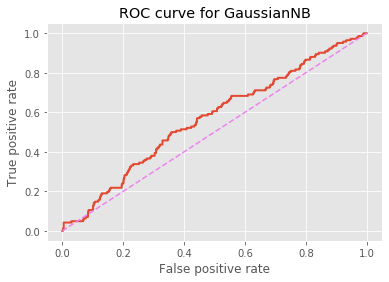

SVC
Accuracy: 0.9221
Precision: 0.3846,   Recall: 0.0704,   f1: 0.1190 

ROC AUC score = 0.5595


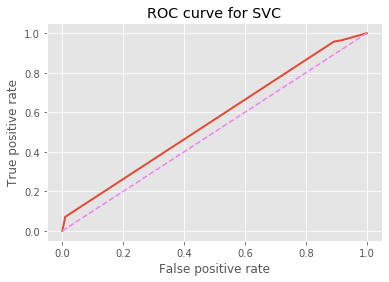

DecisionTreeClassifier
Accuracy: 0.8801
Precision: 0.1641,   Recall: 0.1479,   f1: 0.1556 

ROC AUC score = 0.5442


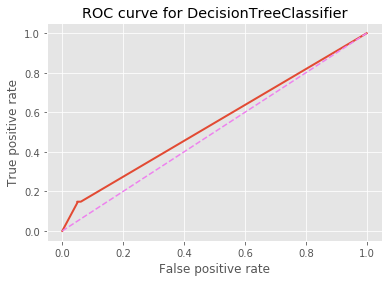

RandomForestClassifier
Accuracy: 0.9137
Precision: 0.3036,   Recall: 0.1197,   f1: 0.1717 

ROC AUC score = 0.6390


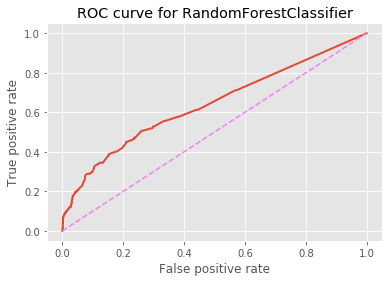

GradientBoostingClassifier
Accuracy: 0.8901
Precision: 0.2403,   Recall: 0.2183,   f1: 0.2288 

ROC AUC score = 0.6162


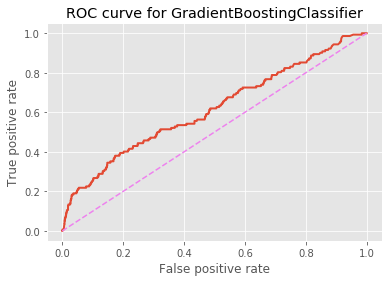



Random Forest feature importances: 

[   ('days_since_release^1', 0.3343869920343311),
    ('positivepercent^1 x days_since_release^1', 0.33391002284389343),
    ('days_since_release^2', 0.33170298512177554)]


Gradient Boosting feature importances: 

[   ('positivepercent^1 x days_since_release^1', 0.4817199827449146),
    ('days_since_release^2', 0.26676940245497444),
    ('days_since_release^1', 0.25151061480011094)]


Best model is  GradientBoostingClassifier
With f1 score of 0.2288 and ROC AUC of 0.6162


GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=100,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=90,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=None, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

In [36]:
classification(exp_Xpoly_sel_6, y, {0: 1, 1: 15})

# 6.1 Ensembling
### Explore the effectiveness of ensembling technique on this problem

##### 6.1.0: Setting up all the models that will be used in Soft Voting Classifier

In [37]:
classweight = {0: 1, 1: 15}

lr_model = LogisticRegression(solver="lbfgs", class_weight= classweight)
nb_model = GaussianNB()
knn_model = KNeighborsClassifier()
svc_model = SVC(probability=True, gamma="scale", class_weight=classweight)
rf_model = RandomForestClassifier(n_estimators=100,class_weight=classweight)
et_model = ExtraTreesClassifier(n_estimators=100, class_weight=classweight)
ada_model = AdaBoostClassifier()

models = ["lr_model", "nb_model", "knn_model", "svc_model", "rf_model", "et_model", "ada_model"]

In [38]:
for model_name in models:
    
    curr_model = eval(model_name)
    
    curr_model.fit(X_train, y_train)
    
    with open(f"models/{model_name}.pickle", "wb") as pfile:
        pickle.dump(curr_model, pfile)

In [39]:
# Load pre-trained/tuned models

model_names = ["lr_model", "nb_model", "knn_model", "svc_model", "rf_model", "et_model", "ada_model"]

import os
# filename = "/tmp/not_exist/filenames.pkl"
# os.makedirs(os.path.dirname(filename), exist_ok=True)

for model_name in model_names:
    filename = f"models/{model_name}.pickle"
    os.makedirs(os.path.dirname(filename), exist_ok=True)
    with open(filename, "rb") as pfile:
        exec(f"{model_name} = pickle.load(pfile)")

model_vars = [eval(n) for n in model_names]
model_list = list(zip(model_names, model_vars))

In [40]:
# Quick peek at each model performance

for model_name in model_names:
    curr_model = eval(model_name)
    print(f'{model_name} score: {curr_model.score(X_test, y_test)}')

lr_model score: 0.06393054459352802
nb_model score: 0.9179163378058406
knn_model score: 0.9344909234411997
svc_model score: 0.06629834254143646
rf_model score: 0.9400157853196527
et_model score: 0.9376479873717443
ada_model score: 0.9376479873717443


#### 6.1.1 Soft Voting Classifier

In [41]:
model_list
# create voting classifier
voting_classifer = VotingClassifier(estimators=model_list,
                                    voting='soft', 
                                    n_jobs=-1)
voting_classifer.fit(X_train, y_train)
y_pred = voting_classifer.predict(X_test)
print ('Accuracy: ', accuracy_score(y_test, y_pred))
print("Precision: {:6.4f},   Recall: {:6.4f},   f1: {:6.4f}".format(precision_score(y_test, y_pred), recall_score(y_test, y_pred), f1_score(y_test, y_pred)), '\n')

Accuracy:  0.9400157853196527
Precision: 1.0000,   Recall: 0.0256,   f1: 0.0500 



ROC AUC score = 0.5975


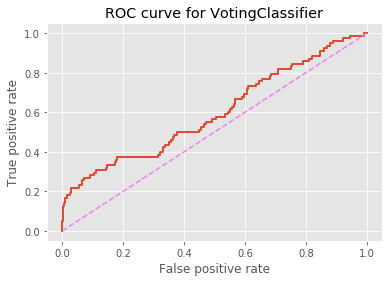

In [42]:
fpr, tpr, thresholds = roc_curve(y_test, voting_classifer.predict_proba(X_test)[:,1])
plt.plot(fpr, tpr,lw=2)
plt.plot([0,1],[0,1],c='violet',ls='--')
plt.xlim([-0.05,1.05])
plt.ylim([-0.05,1.05])
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve for ' + type(voting_classifer).__name__);
print("ROC AUC score = {:6.4f}".format(roc_auc_score(y_test, voting_classifer.predict_proba(X_test)[:,1])))
plt.show()

#### 6.1.2 Stacking Classifier

In [43]:
stacked = StackingClassifier(
    classifiers=model_vars, meta_classifier=BernoulliNB(), use_probas=False)

In [44]:
stacked.fit(X_train, y_train)

StackingClassifier(average_probas=False,
                   classifiers=[LogisticRegression(C=1.0,
                                                   class_weight={0: 1, 1: 15},
                                                   dual=False,
                                                   fit_intercept=True,
                                                   intercept_scaling=1,
                                                   l1_ratio=None, max_iter=100,
                                                   multi_class='auto',
                                                   n_jobs=None, penalty='l2',
                                                   random_state=None,
                                                   solver='lbfgs', tol=0.0001,
                                                   verbose=0,
                                                   warm_start=False),
                                GaussianNB(priors=None, var_smoothing=1e-09),
                            

In [45]:
y_pred = stacked.predict(X_test)
print ('Accuracy: ', accuracy_score(y_test, y_pred))
print("Precision: {:6.4f},   Recall: {:6.4f},   f1: {:6.4f}".format(precision_score(y_test, y_pred), recall_score(y_test, y_pred), f1_score(y_test, y_pred)), '\n')

Accuracy:  0.9368587213891081
Precision: 0.4500,   Recall: 0.1154,   f1: 0.1837 



ROC AUC score = 0.5677


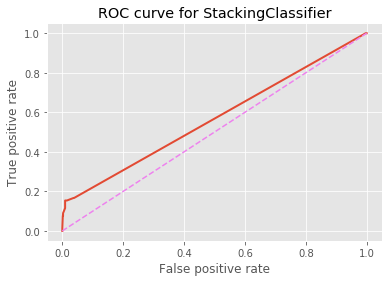

In [46]:
fpr, tpr, thresholds = roc_curve(y_test, stacked.predict_proba(X_test)[:,1])
plt.plot(fpr, tpr,lw=2)
plt.plot([0,1],[0,1],c='violet',ls='--')
plt.xlim([-0.05,1.05])
plt.ylim([-0.05,1.05])
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve for ' + type(stacked).__name__);
print("ROC AUC score = {:6.4f}".format(roc_auc_score(y_test, stacked.predict_proba(X_test)[:,1])))
plt.show()

# 7.1 Best model threshold tweaking
### Best model selected based on previous scores

#### 7.1.0 Best model is Gradient Boosting classifier
with Poly transformed dataset and features with at least 5 votes based on feature_selection

best_model=classification(exp_Xpoly_sel_5, y, {0: 1, 1: 15})

##### 7.1.1: Run threshold checking

best_model best F1 score 0.758 at prob decision threshold >= 0.369


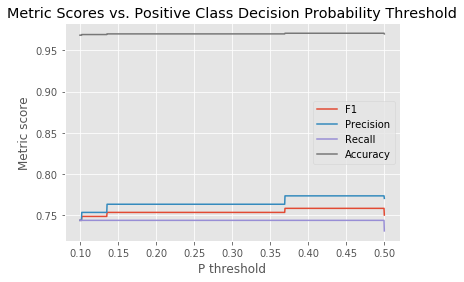

In [48]:
X, y  = exp_Xpoly_sel_5, y
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=42)
X_val, y_val = X_test, y_test # explicitly calling this validation since we're using it for selection

thresh_ps = np.linspace(.10,.50,1000)
model_val_probs = best_model.predict_proba(X_val)[:,1] # positive class probs, same basic logistic model we fit in section 2 

f1_scores, prec_scores, rec_scores, acc_scores = [], [], [], []
for p in thresh_ps:
    model_val_labels = model_val_probs >= p
    f1_scores.append(f1_score(y_val, model_val_labels))    
    prec_scores.append(precision_score(y_val, model_val_labels))
    rec_scores.append(recall_score(y_val, model_val_labels))
    acc_scores.append(accuracy_score(y_val, model_val_labels))
    
plt.plot(thresh_ps, f1_scores)
plt.plot(thresh_ps, prec_scores)
plt.plot(thresh_ps, rec_scores)
plt.plot(thresh_ps, acc_scores)

plt.title('Metric Scores vs. Positive Class Decision Probability Threshold')
plt.legend(['F1','Precision','Recall','Accuracy'])
plt.xlabel('P threshold')
plt.ylabel('Metric score')

best_f1_score = np.max(f1_scores) 
best_thresh_p = thresh_ps[np.argmax(f1_scores)]

print('best_model best F1 score %.3f at prob decision threshold >= %.3f' 
      % (best_f1_score, best_thresh_p))

# 8.1 Deployment and Visualization preparation
### Pickling for web deployment + Writing back to CSV for Tableau viz

##### 8.1.1: Pickle the best model

In [49]:
bestmodel = best_model

In [50]:
with open("models/best_classification_model.pickle", "wb") as pfile:
    pickle.dump(bestmodel, pfile)

##### 8.1.2: Adding predicted probability as a column to the dataframe and export as csv

In [51]:
X_export = exp_Xpoly_sel_5

In [52]:
X_export.describe()

,reviewcount^1,positivepercent^1,days_since_release^1,reviewcount^1 x originalprice^1,reviewcount^1 x days_since_release^1,positivepercent^1 x originalprice^1,positivepercent^1 x days_since_release^1,originalprice^1 x days_since_release^1,days_since_release^2,days_since_release^1 x multiplatform^1
count,6335.00,6335.00,6335.00,6335.00,6335.00,6335.00,6335.00,6335.00,6335.00,6335.00
mean,1061.03,59.90,1285.20,25296.77,1755684.60,679.71,79728.80,13008.11,2606732.22,601.47
std,16914.32,32.51,977.31,485626.29,21362378.26,758.47,83029.18,16942.33,4036923.59,871.59
min,5.00,0.00,25.00,4.95,155.00,0.00,0.00,24.75,625.00,0.00
25%,13.00,45.00,561.50,69.93,10370.00,131.34,15077.50,3125.31,315282.50,0.00
50%,39.00,71.00,1074.00,293.58,36825.00,459.54,59254.00,7405.16,1153476.00,0.00
75%,204.00,85.00,1764.50,2124.34,238767.50,943.89,117005.00,15950.03,3113460.50,1106.00
max,1180658.00,100.00,7128.00,35407933.42,1025991802.00,8909.19,684288.00,251530.65,50808384.00,7128.00


In [53]:
X_export['pred_proba'] = bestmodel.predict_proba(X_export)[:, 1]

In [54]:
X_export.head(5)

,reviewcount^1,positivepercent^1,days_since_release^1,reviewcount^1 x originalprice^1,reviewcount^1 x days_since_release^1,positivepercent^1 x originalprice^1,positivepercent^1 x days_since_release^1,originalprice^1 x days_since_release^1,days_since_release^2,days_since_release^1 x multiplatform^1,pred_proba
0,68938.00,79.00,1296.00,4135590.62,89343648.00,4739.21,102384.00,77747.04,1679616.00,1296.00,1.00
1,539688.00,88.00,1620.00,10788363.12,874294560.00,1759.12,142560.00,32383.80,2624400.00,0.00,0.00
2,236.00,74.00,1151.00,2357.64,271636.00,739.26,85174.00,11498.49,1324801.00,0.00,0.00
3,560.00,61.00,1935.00,72794.40,1083600.00,7929.39,118035.00,251530.65,3744225.00,1935.00,0.00
4,254.00,67.00,1935.00,2537.46,491490.00,669.33,129645.00,19330.65,3744225.00,0.00,0.00


In [55]:
X_export.to_csv("csv_for_tableau/best_classification_model.csv")

# 9.1 Final Result
### visit: https://steam-discount-predictor.herokuapp.com/
### see the Medium blog post: https://medium.com/@opophehu/supervised-classification-a0043d0c5ba5